<a href="https://colab.research.google.com/github/Gaganpyla/Transformer-Based-Network-Intrusion-Detection-System/blob/main/Transformer-Based%20Network%20Intrusion%20Detection%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#preprocessing
import pandas as pd
import numpy as np

train_df = pd.read_parquet("UNSW_NB15_training-set.parquet")
test_df  = pd.read_parquet("UNSW_NB15_testing-set.parquet")

print(train_df.shape, test_df.shape)

# 0 = Normal, 1 = Attack
train_df["binary_label"] = train_df["label"]
test_df["binary_label"]  = test_df["label"]

drop_cols = ["id", "attack_cat", "label"]

train_df = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
test_df  = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])

def clean_df(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    return df

train_df = clean_df(train_df)
test_df  = clean_df(test_df)

X_train = train_df.drop(columns=["binary_label"])
y_train = train_df["binary_label"]

X_test  = test_df.drop(columns=["binary_label"])
y_test  = test_df["binary_label"]

from sklearn.preprocessing import LabelEncoder

cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col])
    X_test[col]  = le.transform(X_test[col])
    encoders[col] = le

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)


(175341, 36) (82332, 36)


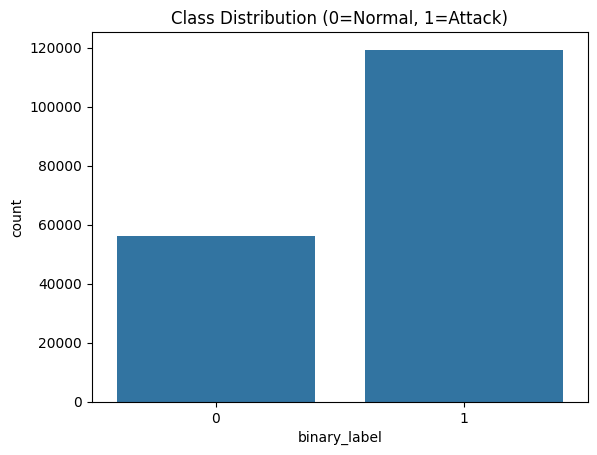

In [ ]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)
plt.title("Class Distribution (0=Normal, 1=Attack)")
plt.show()


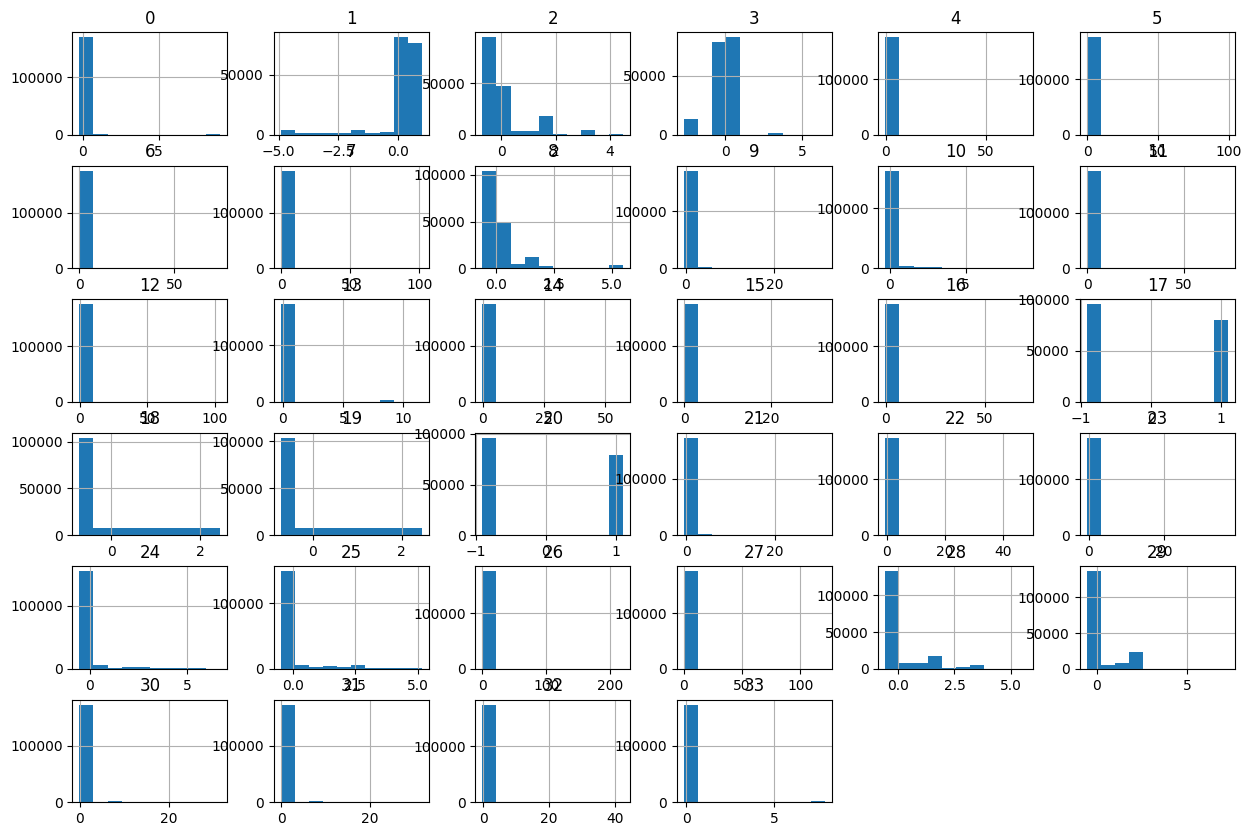

In [ ]:
pd.DataFrame(X_train_scaled).hist(figsize=(15,10))
plt.show()


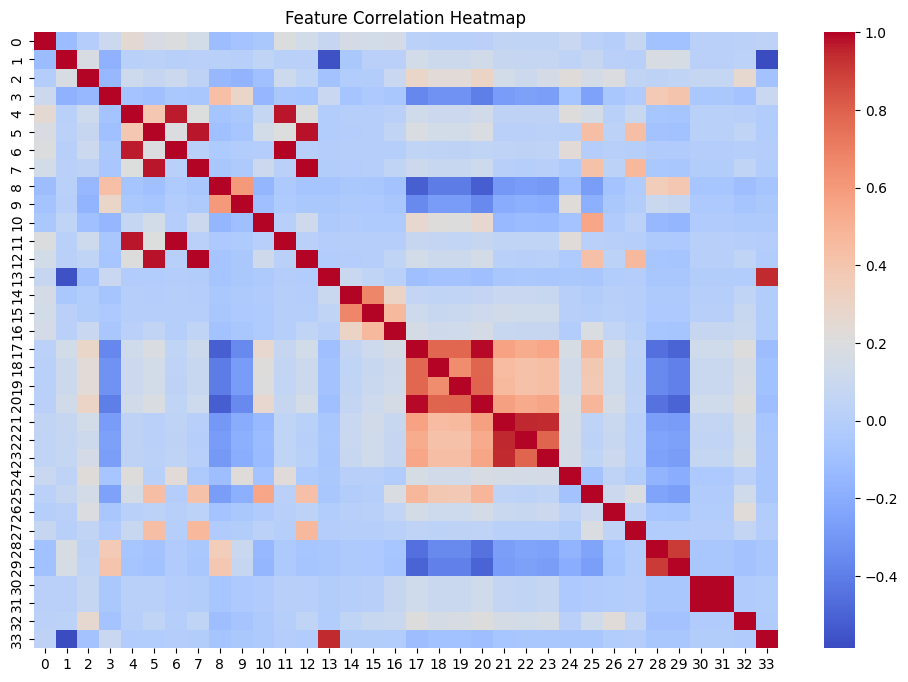

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(X_train_scaled).corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
#Pytorch setup
import torch
from torch.utils.data import Dataset, DataLoader

class UNSWDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128

train_dataset = UNSWDataset(X_train_final, y_train_final)
val_dataset   = UNSWDataset(X_val, y_val)
test_dataset  = UNSWDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
#Linformer
class LightweightAttention(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.q = torch.nn.Linear(d_model, d_model)
        self.k = torch.nn.Linear(d_model, d_model)
        self.v = torch.nn.Linear(d_model, d_model)
        self.out = torch.nn.Linear(d_model, d_model)

    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        attn = torch.softmax(Q @ K.transpose(-2, -1) / (x.shape[-1] ** 0.5), dim=-1)
        return self.out(attn @ V)

class LinformerBlock(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = LightweightAttention(d_model)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.ff = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.ReLU(),
            torch.nn.Linear(d_model, d_model)
        )
        self.norm2 = torch.nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class LinformerIDS(torch.nn.Module):
    def __init__(self, input_dim, d_model, num_layers):
        super().__init__()
        self.embedding = torch.nn.Linear(input_dim, d_model)
        self.layers = torch.nn.ModuleList([LinformerBlock(d_model) for _ in range(num_layers)])
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(d_model, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        for layer in self.layers:
            x = layer(x)
        x = x[:, 0, :]
        return self.classifier(x)


In [ ]:
#Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_final),
    y=y_train_final
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score

def train_one_epoch(model, dataloader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast("cuda"):
            outputs = model(X)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def train_model(model, train_loader, val_loader, epochs=25, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    scaler = GradScaler()

    for epoch in range(epochs):
        loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        y_true, y_pred = evaluate(model, val_loader)
        f1 = f1_score(y_true, y_pred)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | F1: {f1:.4f}")

    return model


In [ ]:
linformer = LinformerIDS(
    input_dim=X_train_final.shape[1],
    d_model=128,
    num_layers=2
)

linformer = train_model(linformer, train_loader, val_loader, epochs=25)


/tmp/ipython-input-2634620154.py:57: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/25 | Loss: 0.1953 | F1: 0.9434


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/25 | Loss: 0.1678 | F1: 0.9398


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3/25 | Loss: 0.1625 | F1: 0.9280


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4/25 | Loss: 0.1587 | F1: 0.9308


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5/25 | Loss: 0.1524 | F1: 0.9281


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6/25 | Loss: 0.1489 | F1: 0.9466


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7/25 | Loss: 0.1481 | F1: 0.9246


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 8/25 | Loss: 0.1460 | F1: 0.9397


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 9/25 | Loss: 0.1454 | F1: 0.9470


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10/25 | Loss: 0.1440 | F1: 0.9454


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11/25 | Loss: 0.1436 | F1: 0.9454


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12/25 | Loss: 0.1415 | F1: 0.9440


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13/25 | Loss: 0.1425 | F1: 0.9442


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14/25 | Loss: 0.1399 | F1: 0.9300


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15/25 | Loss: 0.1397 | F1: 0.9462


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 16/25 | Loss: 0.1399 | F1: 0.9471


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 17/25 | Loss: 0.1386 | F1: 0.9370


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 18/25 | Loss: 0.1395 | F1: 0.9429


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 19/25 | Loss: 0.1375 | F1: 0.9455


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 20/25 | Loss: 0.1375 | F1: 0.9409


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 21/25 | Loss: 0.1374 | F1: 0.9476


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 22/25 | Loss: 0.1368 | F1: 0.9488


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 23/25 | Loss: 0.1360 | F1: 0.9475


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 24/25 | Loss: 0.1358 | F1: 0.9463


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 25/25 | Loss: 0.1364 | F1: 0.9458


In [ ]:
#Evaluation
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

y_true, y_pred = evaluate(linformer, test_loader)

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
print(classification_report(y_true, y_pred))



Accuracy: 0.8852329592382063
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     37000
           1       0.87      0.93      0.90     45332

    accuracy                           0.89     82332
   macro avg       0.89      0.88      0.88     82332
weighted avg       0.89      0.89      0.88     82332



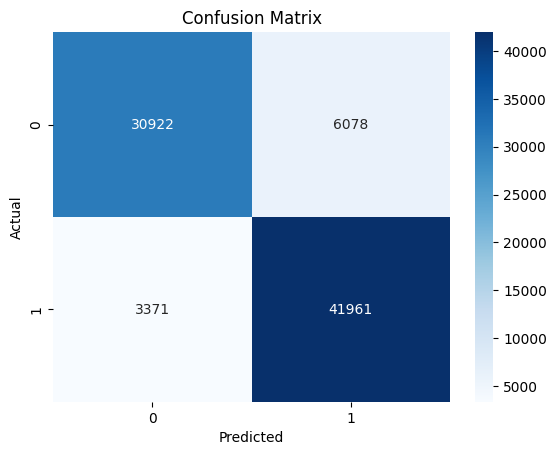

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


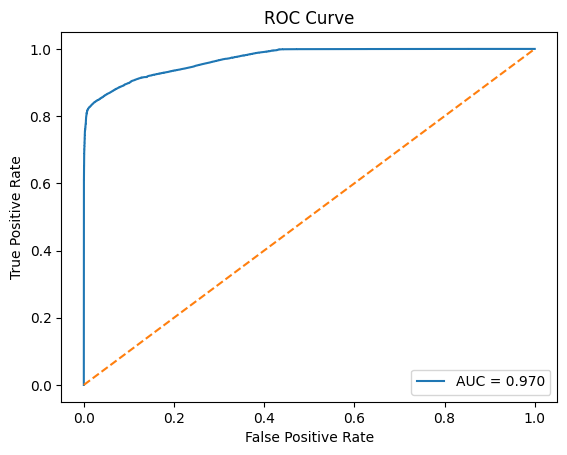

In [ ]:
model_outputs = []

linformer.eval()
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        outputs = linformer(X)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        model_outputs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, model_outputs)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
def load_arff_manual(filepath):
    data = []
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("@") or line.startswith("%"):
                continue
            values = [v.strip().strip("'") for v in line.split(",")]
            data.append(values)
    return pd.DataFrame(data)

nsl_df = load_arff_manual("KDDTest+.arff")
print(nsl_df.shape)
nsl_df.head()

nsl_columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
    "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "class"
]

nsl_df.columns = nsl_columns


(22544, 42)


In [ ]:
#converting Labels to Binary
nsl_df["binary_label"] = nsl_df["class"].apply(lambda x: 0 if x == "normal" else 1)
nsl_df.drop(columns=["class"], inplace=True)

#Encoding Categorial columns
cat_cols = nsl_df.select_dtypes(include=["object"]).columns

from sklearn.preprocessing import LabelEncoder

nsl_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    nsl_df[col] = le.fit_transform(nsl_df[col])
    nsl_encoders[col] = le

#Feature Alignment

# Get UNSW feature names from training
unsw_features = X_train.columns.tolist()  # from your earlier code

# Remove label
if "binary_label" in unsw_features:
    unsw_features.remove("binary_label")

# Drop NSL label column for X
X_nsl = nsl_df.drop(columns=["binary_label"])
y_nsl = nsl_df["binary_label"]

# Add missing columns
for col in unsw_features:
    if col not in X_nsl.columns:
        X_nsl[col] = 0

# Remove extra columns
X_nsl = X_nsl[unsw_features]

X_nsl_scaled = scaler.transform(X_nsl)


In [ ]:
class NSLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

nsl_dataset = NSLDataset(X_nsl_scaled, y_nsl)
nsl_loader = DataLoader(nsl_dataset, batch_size=128, shuffle=False)



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_true_nsl, y_pred_nsl = evaluate(linformer, nsl_loader)

acc_nsl = accuracy_score(y_true_nsl, y_pred_nsl)

print("NSL-KDD Accuracy:", acc_nsl)
print(classification_report(y_true_nsl, y_pred_nsl))


NSL-KDD Accuracy: 0.7370919091554294
              precision    recall  f1-score   support

           0       0.65      0.83      0.73      9711
           1       0.84      0.66      0.74     12833

    accuracy                           0.74     22544
   macro avg       0.75      0.75      0.74     22544
weighted avg       0.76      0.74      0.74     22544



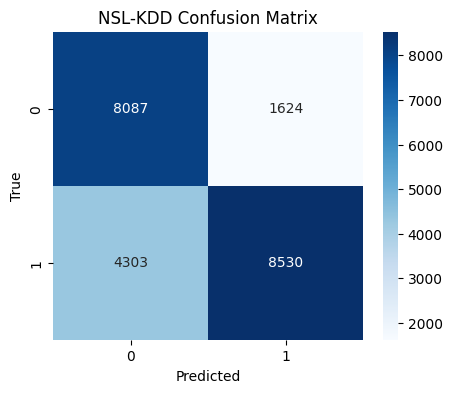

In [ ]:
cm_nsl = confusion_matrix(y_true_nsl, y_pred_nsl)

plt.figure(figsize=(5,4))
sns.heatmap(cm_nsl, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("NSL-KDD Confusion Matrix")
plt.show()


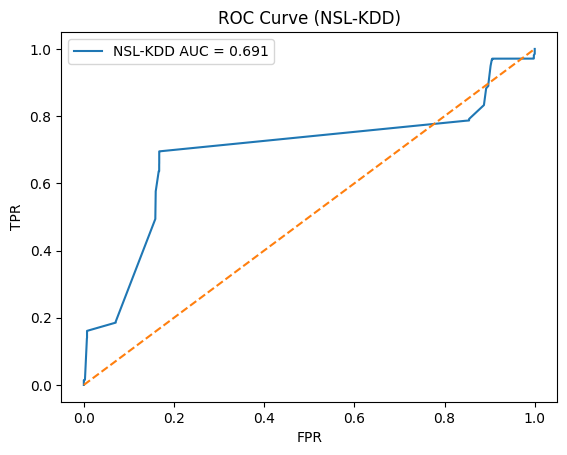

In [ ]:
probs_nsl = []

linformer.eval()
with torch.no_grad():
    for X, _ in nsl_loader:
        X = X.to(device)
        outputs = linformer(X)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        probs_nsl.extend(probs.cpu().numpy())

fpr_nsl, tpr_nsl, _ = roc_curve(y_true_nsl, probs_nsl)
auc_nsl = auc(fpr_nsl, tpr_nsl)

plt.plot(fpr_nsl, tpr_nsl, label=f"NSL-KDD AUC = {auc_nsl:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (NSL-KDD)")
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import f1_score

f1_unsw = f1_score(y_true, y_pred)
f1_nsl  = f1_score(y_true_nsl, y_pred_nsl)

print("UNSW F1:", f1_unsw)
print("NSL-KDD F1:", f1_nsl)


UNSW F1: 0.8988015550866971
NSL-KDD F1: 0.7421586113890459


In [ ]:
results_table = pd.DataFrame({
    "Dataset": ["UNSW-NB15", "NSL-KDD"],
    "Accuracy": [acc, acc_nsl],
    "AUC": [roc_auc, auc_nsl],
    "F1-Score": [f1_unsw, f1_nsl]
})

results_table


,Dataset,Accuracy,AUC,F1-Score
0,UNSW-NB15,0.885233,0.970324,0.898802
1,NSL-KDD,0.737092,0.690848,0.742159


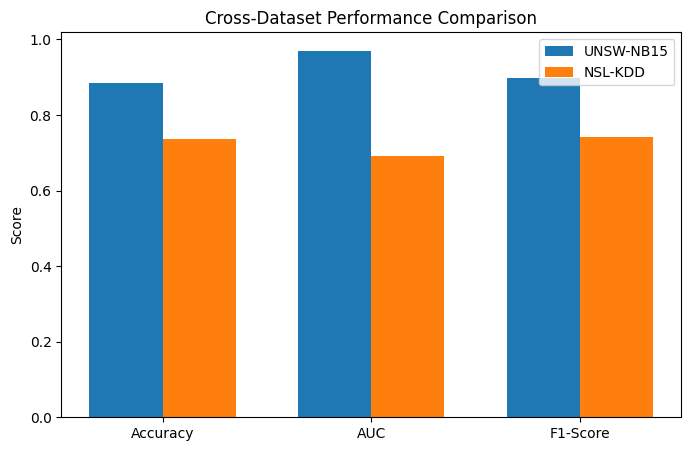

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Accuracy", "AUC", "F1-Score"]
unsw_vals = [acc, roc_auc, f1_unsw]
nsl_vals  = [acc_nsl, auc_nsl, f1_nsl]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, unsw_vals, width, label="UNSW-NB15")
plt.bar(x + width/2, nsl_vals, width, label="NSL-KDD")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Cross-Dataset Performance Comparison")
plt.legend()
plt.show()
